<a href="https://colab.research.google.com/github/vkatiyar/Symposium_HU/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data


### Downloading the data from Google Drive

In [1]:
# provided by turdus-merula at https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [2]:
file_id = '1136vzY1DMDnBzesG9NAdD0CE0_-rsPW8'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [3]:
import zipfile
def unzip_func(file):  
    with zipfile.ZipFile(file, 'r') as zip_f:
        zip_f.extractall()

In [4]:
unzip_func(destination)

In [5]:
import os, shutil, glob
import numpy as np

In [6]:
# root_dir = "data"
dataset_path = '/content/NWPU-RESISC45_Lakes_Data'


In [7]:
# Print all the files 
for file in os.walk(dataset_path):
  print(file)

('/content/NWPU-RESISC45_Lakes_Data', [], ['lake_012.jpg', 'lake_008.jpg', 'lake_041.jpg', 'lake_042.jpg', 'lake_010.jpg', 'lake_062.jpg', 'lake_068.jpg', 'lake_021.jpg', 'lake_075.jpg', 'lake_005.jpg', 'lake_024.jpg', 'lake_084.jpg', 'lake_034.jpg', 'lake_033.jpg', 'lake_065.jpg', 'lake_045.jpg', 'lake_037.jpg', 'lake_072.jpg', 'lake_038.jpg', 'lake_069.jpg', 'lake_017.jpg', 'lake_049.jpg', 'lake_060.jpg', 'lake_006.jpg', 'lake_058.jpg', 'lake_059.jpg', 'lake_025.jpg', 'lake_061.jpg', 'lake_028.jpg', 'lake_097.jpg', 'lake_088.jpg', 'lake_057.jpg', 'lake_070.jpg', 'lake_056.jpg', 'lake_022.jpg', 'lake_095.jpg', 'lake_052.jpg', 'lake_071.jpg', 'lake_054.jpg', 'lake_018.jpg', 'lake_001.jpg', 'lake_083.jpg', 'lake_043.jpg', 'lake_031.jpg', 'lake_026.jpg', 'lake_082.jpg', 'lake_091.jpg', 'lake_090.jpg', 'lake_086.jpg', 'lake_004.jpg', 'lake_100.jpg', 'lake_046.jpg', 'lake_077.jpg', 'lake_023.jpg', 'lake_089.jpg', 'lake_099.jpg', 'lake_078.jpg', 'lake_013.jpg', 'lake_076.jpg', 'lake_094.jpg

In [8]:
# install rasterio
!pip3 install rasterio

     |████████████████████████████████| 18.3MB 169kB/s 


## Read images and json file

In [9]:
import rasterio 
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

def read_rasterio_image(img_path):
    with rasterio.open(img_path) as f_arr:        
        return(f_arr.read().transpose(1,2,0)) # transpose (CxHxW=>HxWxC)

In [10]:
temp_im = 'lake_001.jpg'
im_arr = read_rasterio_image(dataset_path + os.sep + temp_im)

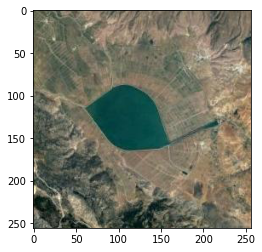

In [11]:
import matplotlib.pyplot as plt
plt.imshow(im_arr)
plt.show()

In [12]:
import json #importing json library for workinng with .json file
with open('/content/NWPU-RESISC45_Lakes_Data/labels_0-100.json','r') as f: # opening the json file, 'open' returns the file object. 
  jsonlabeldata = json.load(f) # load function returns json object as a dictionary

In [13]:
# %rm -rf '/content/NWPU-RESISC45_Lakes_Data/'

In [14]:
temp_labeldata = jsonlabeldata[temp_im]
x = temp_labeldata['regions']['0']['shape_attributes']['all_points_x']
y = temp_labeldata['regions']['0']['shape_attributes']['all_points_y']

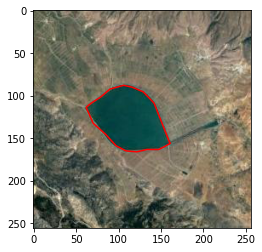

In [15]:
%matplotlib inline
plt.imshow(im_arr)
plt.plot(x,y,'r')

## Convert the labels from polygon to masks

In [16]:
'''Read polygan co-ordinates from JSON 
  returns: X = list of coordiate values of 'x' of all the regions.
          Y = list of coordiate values of 'y' of all the regions.
'''
def get_polygon(image,jsonData ):
    regions = jsonData[os.path.basename(image)]['regions'] # listing all the regions
    X = []
    Y = []
    print ('Number of polygons are {} in the file {}'.format(len(regions),image))

    for region_num in regions:
        X.append (regions[region_num]['shape_attributes']['all_points_x'])
        Y.append (regions[region_num]['shape_attributes']['all_points_y'])
    return (X,Y)


In [17]:
tmp_x, tmp_y = get_polygon(temp_im,jsonlabeldata)

Number of polygons are 1 in the file lake_001.jpg


In [18]:
# import some drawing tools from PIL
from PIL import Image, ImageDraw

def createMaskfromLabel(img_width, img_height, coordinates):
    mask = np.zeros((img_height,img_width))
    nx = img_width
    ny = img_height
    X,Y = coordinates
    for x,y in zip(X,Y):
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()
        img = Image.new('L', (nx, ny), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        # turn into a numpy array
        m = np.array(img)
        mask = mask + m
        mask = mask + np.array(img)
    return 255*(mask > 0).astype(int)

[  0 255]


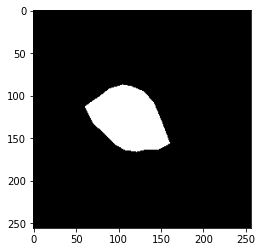

In [19]:
tmp_mask = createMaskfromLabel(256,256,[tmp_x,tmp_y])
print(np.unique(tmp_mask))
plt.imshow(tmp_mask, cmap='gray')

## Save the masks in the disk

In [20]:
import matplotlib.image as mplImage
def write_mask(mask, mask_name, mask_path):
    # mask_rasterioformat = mask.transpose() # convert from WxHxC to CxHxW
    if (os.path.isdir(mask_path)):
        mplImage.imsave(os.path.join(mask_path,mask_name), mask.astype('uint8'))

In [21]:
print("Writing mask- ...")   
for img in sorted(glob.glob(dataset_path+os.sep+'*[0-9].jpg')):
    img_width,img_height = np.shape(read_rasterio_image(img))[0:2]
    coord = get_polygon(os.path.basename(img),jsonlabeldata)
    mask = createMaskfromLabel(img_width,img_height,coord)
    mask_name = os.path.basename(img).split('.')[0]+'_mask.'+os.path.basename(img).split('.')[1]
    write_mask(mask,mask_name,dataset_path)
print(' Done!')

Writing mask- ...
Number of polygons are 1 in the file lake_001.jpg
Number of polygons are 1 in the file lake_002.jpg
Number of polygons are 2 in the file lake_003.jpg
Number of polygons are 5 in the file lake_004.jpg
Number of polygons are 3 in the file lake_005.jpg
Number of polygons are 1 in the file lake_006.jpg
Number of polygons are 2 in the file lake_007.jpg
Number of polygons are 1 in the file lake_008.jpg
Number of polygons are 4 in the file lake_009.jpg
Number of polygons are 1 in the file lake_010.jpg
Number of polygons are 25 in the file lake_011.jpg
Number of polygons are 1 in the file lake_012.jpg
Number of polygons are 4 in the file lake_013.jpg
Number of polygons are 2 in the file lake_014.jpg
Number of polygons are 13 in the file lake_015.jpg
Number of polygons are 2 in the file lake_016.jpg
Number of polygons are 1 in the file lake_017.jpg
Number of polygons are 1 in the file lake_018.jpg
Number of polygons are 24 in the file lake_019.jpg
Number of polygons are 1 in t

[0. 1.]


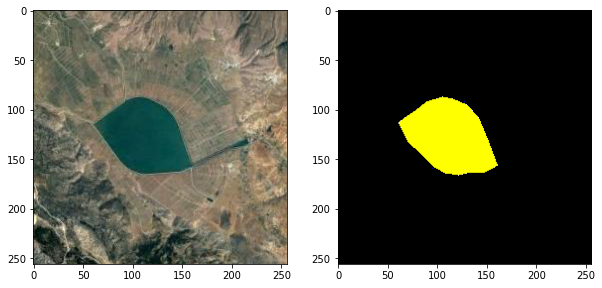

In [24]:
im_arr1 = read_rasterio_image(dataset_path + os.sep +'lake_001.jpg')
label_arr1 = read_rasterio_image(dataset_path + os.sep +'lake_001_mask.jpg')

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(im_arr1)
ax[1].imshow((label_arr1>150).astype(float).squeeze(), cmap='gray')
print(np.unique((label_arr1>150).astype(float)))

# Prepare the system

In [25]:
import tensorflow as tf
# checking the GPU availibility
if (len(tf.config.list_physical_devices('GPU'))):
  print("Total available GPU's are =",len(tf.config.list_physical_devices('GPU')))
else:
  print("No GPU is available.")

Total available GPU's are = 1


# Preprocessing and readying the data

In [26]:
# some utilities methods

def load_all_images(data_path, img_ext='jpg'):
    return np.array([read_rasterio_image(str(p)) for p in 
                                    sorted(glob.glob(data_path+os.sep+"[a-z,A-Z]*."+img_ext))])

# for better visulaization of image with the masks
def paired_image_and_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    return np.concatenate([img, mask], axis = 1)

def show_combined_plots(x=[], y=[], batch_size, figsize=(8,8)):
  cols = 2
  rows = batch_size//cols
  fig, axs = plt.subplots(rows, cols, figsize = figsize)
  axs = axs.flatten()
  for i in range (0, batch_size):
    combined = paired_image_and_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

  plt.tight_layout()

## Making train,validation and test set

In [27]:
train_dir = dataset_path+os.sep+"train"
val_dir = dataset_path+os.sep+"val"
test_dir = dataset_path+os.sep+"test"

# IMG_WIDTH,IMG_HEIGHT = (256,256)


Divide the data into three:
* ***train set***
* ***validataion set***
* ***test set***

The Hierarachy structure will be as follows:

```
    Dataset_Path
        \
         test
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |            -> *_mask.jpg mask images
         |
         train
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |            -> *_mask.jpg mask images
         |
         val
         |    \
         |     images
         |     |     \
         |     |      -> *.jpg of actual lakes
         |     masks
         |          \
         |           -> *_mask.jpg mask images
         |

 ```

In [28]:
import errno # standard library to check the error type
try:
    os.mkdir(train_dir)
    os.mkdir(train_dir+os.sep+ 'images')
    os.mkdir(train_dir+os.sep+ 'masks')

    os.mkdir(val_dir)
    os.mkdir(val_dir+os.sep+ 'images')
    os.mkdir(val_dir+os.sep+ 'masks')

    os.mkdir(test_dir)
    os.mkdir(test_dir+os.sep+ 'images')
    os.mkdir(test_dir+os.sep+ 'masks')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    print('Directory already existing.')
    pass

In [29]:
import random 
random.seed (100) # To ensure that everyone have same datasets
def move_images_mask(imgs,foldername):
  for img in imgs:
    imgName = os.path.basename(img)
    maskName = os.path.basename(img).split('.')[0]+'_mask.jpg'
    src = dataset_path+os.sep
    dst = dataset_path+os.sep+foldername+os.sep
    # print("Val Source = {}, destination = {}".format(src,dst))
    shutil.move(src+imgName,dst+'images/'+imgName)
    shutil.move(src+maskName,dst+'masks/'+maskName)
  print('Files moved in "{}".'.format(foldername)) 

all_images = glob.glob(dataset_path+os.sep+'*[0-9].jpg')
val_test = random.sample(all_images,int(0.3*len(all_images)))
test = random.sample(val_test,int(0.3*len(val_test)))
val = [img for img in val_test if img not in test] 

move_images_mask(test,'test')
move_images_mask(val,'val')
move_images_mask(glob.glob(dataset_path+os.sep+'*[0-9].jpg'),'train')

Files moved in "test".
Files moved in "val".
Files moved in "train".


## Reading and normalizing all the datasets.

In [30]:
train_imgs = load_all_images (train_dir+os.sep+'/images')
train_masks = load_all_images(train_dir+os.sep+'/masks')
val_imgs = load_all_images (val_dir+os.sep+'/images')
val_masks = load_all_images(val_dir+os.sep+'/masks')
test_imgs = load_all_images(test_dir+os.sep+'/images')
test_masks = load_all_images(test_dir+os.sep+'/masks')
print("Number of train images = {}, masks = {}".format(len(train_imgs),len(train_masks)))
print("Shape of 'train_imgs' = {}, 'train_masks' = {}".format(np.shape(train_imgs),np.shape(train_masks)))
print("Shape of 'val_imgs' = {}, 'val_masks' = {}".format(np.shape(val_imgs),np.shape(val_masks)))
print("Shape of 'test_imgs' = {}, 'test_masks' = {}".format(np.shape(test_imgs),np.shape(test_masks)))

Number of train images = 70, masks = 70
Shape of 'train_imgs' = (70, 256, 256, 3), 'train_masks' = (70, 256, 256, 3)
Shape of 'val_imgs' = (21, 256, 256, 3), 'val_masks' = (21, 256, 256, 3)
Shape of 'test_imgs' = (9, 256, 256, 3), 'test_masks' = (9, 256, 256, 3)


In [31]:
train_imgs = train_imgs/255.
test_imgs = test_imgs/255.
val_imgs = val_imgs/255.
train_masks = (train_masks[:,:,:,0:1]>150).astype(float)
test_masks = (test_masks[:,:,:,0:1]>150).astype(float)
val_masks = (val_masks[:,:,:,0:1]>150).astype(float)
print("Shape of 'train_imgs' = {}, 'train_masks' = {}".format(np.shape(train_imgs),np.shape(train_masks)))
print("Shape of 'val_imgs' = {}, 'val_masks' = {}".format(np.shape(val_imgs),np.shape(val_masks)))
print("Shape of 'test_imgs' = {}, 'test_masks' = {}".format(np.shape(test_imgs),np.shape(test_masks)))

Shape of 'train_imgs' = (70, 256, 256, 3), 'train_masks' = (70, 256, 256, 1)
Shape of 'val_imgs' = (21, 256, 256, 3), 'val_masks' = (21, 256, 256, 1)
Shape of 'test_imgs' = (9, 256, 256, 3), 'test_masks' = (9, 256, 256, 1)


In [37]:
print(np.unique(val_masks))

[0. 1.]


# Build the model

Here we will be building one of the very famous network architecure used for segmentation- [UNet](https://arxiv.org/pdf/1505.04597.pdf). It has been build for the medical imaging segmentation and have shown a great result with lesser amount of training data.

**More materials on UNet:**
* [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/) by Francois Chollet
* [Implementation of deep learning framework -- Unet, using Keras](https://github.com/zhixuhao/unet) by the author of the orginal paper

***More on CNN:***
* [Convolutional Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

In [38]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = (256,256,3) # Training images shape

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

In [50]:
# Build U-Net model
def UNet(filters = 8, pretrained_weights = None, input_size = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs) #256x256x8
    conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)  #256x256x8
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)                                                         #128x128x8
    conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1) #128x128x16
    conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) #128x128x16
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)                                                         #64x64x16
    conv3 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2) #64x64x32
    conv3 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3) #64x64x32
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)                                                         #32x32x32
    conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3) #32x32x64
    conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4) #32x32x64
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)                                                         #16x16x64

    conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4) #16x16x128
    conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5) #16x16x128
    up6 = Conv2DTranspose(filters*16, 2, strides=(2, 2), padding='same') (conv5)                                  #32x32x128
    
    merge6 = concatenate([conv4,up6], axis = 3)                                                            #32x32x192
    conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6) #32x32x64
    conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)  #32x32x64
    up7 = Conv2DTranspose(filters*8, 2, strides=(2, 2), padding='same') (conv6)                                   #64x64x64

    merge7 = concatenate([conv3,up7], axis = 3)                                                            #64x64x96
    conv7 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7) #64x64x32
    conv7 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)  #64x64x32
    up8 = Conv2DTranspose(filters*4, 2, strides=(2, 2), padding='same') (conv7)                                   #128x128x32

    merge8 = concatenate([conv2,up8], axis = 3)                                                            #128x128x48
    conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8) #128x128x16
    conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)  #128x128x16
    up9 = Conv2DTranspose(filters*2, 2, strides=(2, 2), padding='same') (conv8)                                   #256x256x16
    
    merge9 = concatenate([conv1,up9], axis = 3)                                                            #256x256x24
    conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)  #256x256x8
    conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)   #256x256x8
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)   #256x256x2
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)                                                   #256x256x1

    model = Model(inputs = inputs, outputs = conv10)
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [52]:
model = UNet(16)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_41[0][0]                  
_______________________________________________________________________________________

# **Training**
* Set Hyperparamater
* Compile the model.
* Start training


In [53]:
BATCH_SIZE = 10
EPOCH = 100


In [54]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [55]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

def training(model,train_img, train_mask, val_img, val_mask, modelName=""):
    earlystopper =  EarlyStopping(patience = 10, verbose = 1)
    modelName = "unet_"+modelName + ".h5"
    checkpointer = ModelCheckpoint(modelName,verbose = 1, save_best_only=True)
    if (not os.path.exists("logs/")):
        os.mkdir("logs/")
    tensorboard = TensorBoard(log_dir = "logs/{}".format(modelName))

    result = model.fit(train_img,train_mask,
              batch_size= BATCH_SIZE,
              validation_data =(val_img,val_mask),
              epochs = EPOCH,
              callbacks=[earlystopper, checkpointer,  tensorboard])
    return result

In [56]:
trainingHistory = training(model,train_imgs, train_masks, val_imgs, val_masks,"8f_bce")

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.7562
Epoch 00001: val_loss improved from inf to 0.69298, saving model to unet_8f_bce.h5
7/7 [==============================] - 1s 167ms/step - loss: 0.6934 - accuracy: 0.7562 - val_loss: 0.6930 - val_accuracy: 0.7635
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.7975
Epoch 00002: val_loss improved from 0.69298 to 0.69278, saving model to unet_8f_bce.h5
7/7 [==============================] - 1s 120ms/step - loss: 0.6929 - accuracy: 0.7975 - val_loss: 0.6928 - val_accuracy: 0.7651
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7992
Epoch 00003: val_loss improved from 0.69278 to 0.69259, saving model to unet_8f_bce.h5
7/7 [==============================] - 1s 115ms/step - loss: 0.6926 - accuracy: 0.7992 - val_loss: 0.6926 - val_accuracy: 0.7662
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.6924 - a

# Tuning Hyperparameter

There are few points on the basis of which we can tune our parameters. These are defined below:

* Look at bias (training data performance): for finding the bias, you will look the difference between the training accuracy and human level accuracy. If there is high bias then it indicates the ***underfitting*** problem.
>* In this case we can look for bigger network to get more abstract features or can train longer to better fit the training data.

* Look at Variance (validation data performance): to get the variance we will see the difference among traing set accuracy and validataion set accuracy. High variance indicates that our model is posssibly ***overfitting*** on the training set.
>* In this case we may look for more data or we can also do some regularization to avoid the overfitting problem





# Prediction and evalaution

In [57]:
# returns a model prediction 
def predictor(model, images_for_prediction):
    decoded_images = model.predict(images_for_prediction)
    return decoded_images

In [58]:
# indexes= np.arange(0,04,2)
predicted_output = predictor(model,test_imgs)

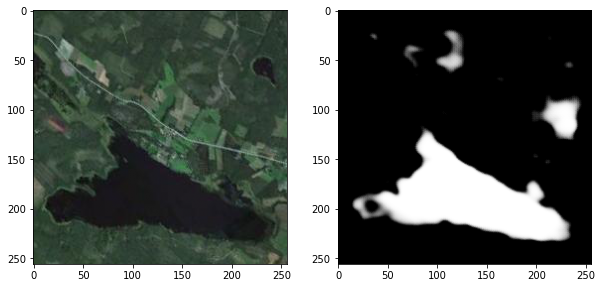

In [59]:

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(test_imgs[0].squeeze())
ax[1].imshow(predicted_output[0].squeeze(),cmap = 'gray')

# Image augmentation

In general, more vaiability in data allows the model to generalise better, which means the performance on the unseen set(test set) will be very good. However, many a time we do not have enough data for model to get better trained. In this situation Image augmentation helps.

Image Augmentation means using the available images to create more number of instances by including some changes in them. Some of these changes can be:
* Rotation
* Translatation
* Flip (Horizontal or Vertical)
* Random cropping
* Random brightness/contrast
* Random zoom
* etc.


## Training using the augmentation through ImageDataGenrator

In [ ]:
def createTrainGenerator(train_dir_path):
    train_data_gen_args = dict(
                        shear_range=0.3,
                        zoom_range=[0.7,1],
                        rotation_range=90,
                        horizontal_flip=True,
                        vertical_flip=True
                              )

    image_datagen = ImageDataGenerator(**train_data_gen_args)
    mask_datagen = ImageDataGenerator(**train_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_dir_path+'/images',
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False, class_mode=None)

    mask_generator = mask_datagen.flow_from_directory(
        train_dir_path+'/masks',
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False, class_mode=None)

    train_generator = ((np.array(pair[0], dtype='float64')/255,np.array(pair[1], dtype='float64')) for pair in 
                       zip(image_generator, mask_generator))
    return train_generator

def createValGenerator(val_dir_path):
    val_data_gen_args = dict(
                    horizontal_flip=True,
                    vertical_flip=True
                          )
    img_datagen = ImageDataGenerator(**val_data_gen_args)
    mk_datagen = ImageDataGenerator(**val_data_gen_args)

    img_generator = img_datagen.flow_from_directory(
        val_dir_path+'/images',
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False, class_mode=None)

    mk_generator = mk_datagen.flow_from_directory(
        val_dir_path+'/masks',
        batch_size= BATCH_SIZE, seed=SEED, shuffle=False, class_mode=None)
    
    val_generator = ((np.array(pair[0], dtype='float64')/255,np.array(pair[1], dtype='float64')) for pair in 
                       zip(img_generator, mk_generator))
    return val_generator

# Other accuracy matrices and loss functions

***IoU***: One of the most popular accuracy metric to evaluate the performance of the semantic segmentation is 'Intersection over Union (IoU)'. IoU focuses on the object shape as a whole rather than comparing the pixel level accuracy.

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

Here $y_{true}$ is the label given and $y_{pred}$ is the prediction of the model.

***Soft Dice Loss***: Many time network tends to ignore smaller classes. In this case dice loss can be used to train a model 


More resources:
[Metrics for semantic segmentation](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html) by Angelo Monteux

In [5]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    #binarize and make a float
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # get the intersection (numerator in above equation) 
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    # get the union (denominator)
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    # compute iou as the ratio unless the denominator is zero
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [6]:
def dice_coef(y_true, y_pred): 
    smooth = 1e-07
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))     
    return (2 * intersection / (union + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)